In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import product
import pandas as pd
import time
import scipy

electron_mass = 0.5109989461*(10**9) # in meV
c_squared = 8.987551787*(10**36) # A^2/s^2
h_bar_squared = (6.582*(10**(-13)))**2 # meV s
hb2m0 = h_bar_squared/(2*(electron_mass/c_squared))
hdim = 61

"""
The class Janus_TMD has three public methods: plot_moire_potential(), plot_BZ(), plot_charge_dist()

"""

class Janus_TMD:
    def __init__(self, material, PATH_V, PATH_inv_emass, twist_angle, alat):
        # Initialize Relevant Lattice Lengths
        self.material = material
        self.twist_angle = twist_angle # degrees
        self.alat = alat # A
        self.Lm = alat / (2 * np.sin(np.radians(self.twist_angle / 2)))
        self.recip_length = (2 / np.sqrt(3)) * (2 * np.pi / self.Lm) # adds in cross/dot product term 2/sqrt(3)
        
        # Array of first 11 shells (counting 0th shell)
        self.g_vecs = self.__make_g_vecs(PATH_V)
        
        # Arrays of moire potential and inv_emass fourier coefficients that match to g_vecs
        self.moire_pot_FC = self.__make_moire_pot(PATH_V)
        self.inv_emass_FC = self.__make_inv_emass(PATH_inv_emass)
        
        # Multiplies by the inverse mass term, taken as the largest one in the table
        self.main_diagonal_coefficient = hb2m0 * np.max(abs(self.inv_emass_FC))
        
        # creates first shell so that we can generate reciprocal space points
        self.first_shell = self.__make_first_shell(self.g_vecs)
        self.g_one = self.first_shell[0]
        self.g_two = self.first_shell[1]
        self.g_five = self.first_shell[4]
        self.g_six = self.first_shell[5]
        
        # Dicts storing all the points, and then two path arrays
        self.K = {
            'coords': (self.g_one + self.g_two) / 3,
            'name': 'K'
        }
        self.Gamma = {
            'coords': np.array([0,0]),
            'name': '\u0393'
        }
        self.M = {
            'coords': self.g_one / 2,
            'name': 'M'
        }
        self.K2 = {
            'coords': (self.g_five + self.g_six) / 3,
            'name': 'K'
        }
        self.main_path = np.array([[self.K,self.Gamma],[self.Gamma,self.M],[self.M,self.K]])
        self.paper_path = np.array([[self.K,self.Gamma],[self.Gamma,self.M],[self.M,self.K2]])
    
    def __str__(self):
        return f"Material: {self.material}. Twisted at {self.twist_angle} deg. Lattice constant: {self.alat} Ang."
    
    # Takes a g_grid and returns the scaled array that's common across all files
    def __scale_all(self, g_grid):
        g_lengths = np.linalg.norm(g_grid, axis=1)
        false_recip = np.min(g_lengths[np.nonzero(g_lengths)])
        return g_grid / false_recip
    
    # Rotates given base_vector around so that it gives the jth vector in the base vector's shell
    def __form_rotate(self, jth, base_vector):
        phi = (jth - 1) * np.pi / 3
        c,s = np.cos(phi),np.sin(phi)
        rot_matrix = np.array([[c,-s],[s,c]])
        return rot_matrix @ base_vector
    
    # Searches for vectors in the scaled g_grid that have length 1 (first shell), and lie in first quadrant or y-axis
    def __find_one_and_two(self, g_grid):
        base_vecs = np.zeros((2,2))
        for i,vecs in enumerate(self.__scale_all(g_grid)):
            if np.isclose(np.linalg.norm(vecs),1,atol=1e-04) and vecs[0]>0 and vecs[1]>0:
                base_vecs[0] = g_grid[i]
            elif np.isclose(np.linalg.norm(vecs),1,atol=1e-04) and np.isclose(vecs[0],0,atol=1e-04) and vecs[1]>1:
                base_vecs[1] = g_grid[i]
        return base_vecs
    
    # Makes an array of the six vectors in the first shell
    def __make_first_shell(self, g_grid):
        g_one,g_two = self.__find_one_and_two(g_grid)
        first_shell = np.zeros((6,2))
        for i in range(6):
            first_shell[i] = self.__form_rotate(i + 1, g_one)
        return first_shell
    
    # Reads the file for the first 7 shells, and fills the remaining ones
    def __make_g_vecs(self, PATH):
        df_raw = pd.read_csv(PATH, delim_whitespace=True, header=None)
        df = df_raw.replace(to_replace='[\(\)]', value='', regex=True)
        g_vecs = np.zeros((61,2))
        for i,coord1 in enumerate(df[0].astype(np.complex128)):
            g_vecs[i][0] = np.real(coord1)
        for j,coord2 in enumerate(df[1].astype(np.complex128)):
            g_vecs[j][1] = np.real(coord2)
        false_recip = np.linalg.norm(g_vecs[19])
        base_vectors = self.__find_one_and_two(g_vecs)
        g1 = base_vectors[0]
        g2 = base_vectors[1]
        shell_bases = np.array([[0,0],  g1, g1+g2, 2*g1, 2*g1+g2, g1+2*g2, 3*g1, 3*g1+g2, 2*g1+2*g2, g1+3*g2, 4*g1])
        for shell,jth in product(range(7,11),range(1,7)):
            index = jth+(shell-1)*6
            g_vecs[index] = self.__form_rotate(jth, shell_bases[shell])
        true_g_vecs = np.zeros((61,2))
        true_g_vecs = self.__scale_all(g_vecs)
        return self.recip_length * true_g_vecs
    
    # Reads the file for inverse mass Fourier Coefficients
    def __make_inv_emass(self, PATH_inv_emass):
        df_inv_emass_raw = pd.read_csv(PATH_inv_emass, delim_whitespace=True, header=None)
        df_inv_emass = df_inv_emass_raw.replace(to_replace = '[\(\)]', value = '', regex=True)
        inv_emass = np.array([coeff for coeff in df_inv_emass[2].astype(np.complex128)])
        return inv_emass
    
    # Reads the file for moire potential Fourier coefficients
    def __make_moire_pot(self, PATH_V):
        df_raw = pd.read_csv(PATH, delim_whitespace=True, header=None)
        df = df_raw.replace(to_replace = '[\(\)]', value = '', regex=True)
        moire_coeffs = np.zeros(61, dtype=np.complex128)
        for i,v_val in enumerate(df[2].astype(np.complex128)):
            moire_coeffs[i] = v_val
        return moire_coeffs
    
    # Goes through all the g_vecs and adds up the moire potential
    def __moire_potential(self, r):
        sum = 0
        for i,vec in enumerate(self.g_vecs):
            sum += abs(self.moire_pot_FC[i]) * np.exp(1j * (r @ vec - np.angle(self.moire_pot_FC[i])))
        return np.real(sum)
    
    # Plots for a given num that guages the number of repeated cells are viewed
    def plot_moire_potential(self, num):
        repeat = num * self.Lm
        side = np.linspace(-repeat, repeat)
        X,Y = np.meshgrid(side, side)
        Z = self.__moire_potential(np.stack([X,Y], axis = -1))
        plt.contourf(X, Y, Z-np.min(Z), 100, cmap = cm.jet)
        plt.colorbar()
        plt.xlabel(f"Moire Potential \u0394(r) Plot (meV)")
    
    # Given a vector, searches through and sees if it matches one of the g_grid
    def __identify_vec(self, recip_vec, g_grid):
        info = -1
        for i,vec in enumerate(g_grid[:37,]):
            if(np.allclose(vec,recip_vec)):
                info = i
        return info
    
    # Takes an individual matrix element, and identifies the appropriate Fourier coefficients
    def __off_diagonal(self, i,j,g_grid):
        g_diff = g_grid[i] - g_grid[j]
        info = self.__identify_vec(g_diff, g_grid)
        if info>0:
            return self.moire_pot_FC[info] + self.inv_emass_FC[info] * (np.linalg.norm(g_diff)**2) * hb2m0
        else:
            return 0
    
    # Create array of off-diagonal terms
    def __off_hamiltonian(self, g_grid):
        H = np.zeros([hdim,hdim],dtype=np.complex128)
        for i,j in product(range(hdim),range(hdim)):
            if i!=j:
                H[i,j] = self.__off_diagonal(i,j,g_grid)
        return H
    
    # Create array of on-diagonal terms
    def __on_hamiltonian(self, k):
        H = np.zeros([hdim,hdim], dtype=np.complex128)
        for i in range(hdim):
            H[i,i] = - self.main_diagonal_coefficient * np.linalg.norm(k + self.g_vecs[i])**2
        return H
    
    # Creates an array of the eigenvalues at each points along a linspace of points
    def __plot_points(self, n, eigens, point1, point2):
        k_path = np.linspace(point1, point2, n)
        H__off_diagonal = self.__off_hamiltonian(self.g_vecs)
        path_evals = np.array([scipy.linalg.eigvalsh(H__off_diagonal + self.__on_hamiltonian(k_i), subset_by_index = [hdim - eigens, hdim - 1]) for k_i in k_path])
        return path_evals
    
    # Plots the band structure
    def plot_BZ(self, n, eigens, main_path):
        time1 = time.time()
        if main_path:
            path_list = self.main_path
        else:
            path_list = self.paper_path
        counter = 0
        xlabel = np.zeros(np.size(path_list,0)+1)
        labels = ["" for i in range(np.size(path_list,0)+1)]
        labels[0] = path_list[0][0]['name']
        print(time.time() - time1)
        for i, pair in enumerate(path_list):
            xlabel[i] = counter
            labels[i] = pair[0]['name']
            path_length = np.linalg.norm(pair[1]['coords'] - pair[0]['coords'])
            x = np.linspace(counter, counter + path_length, num=n)
            y = self.__plot_points(n, eigens, pair[0]['coords'], pair[1]['coords'])
            counter += path_length
            for i in range(eigens):
#                 plt.scatter(x,y[:,i],color='0',s = 5)
                plt.plot(x,y[:,i],color='0')
            print(time.time() - time1)
        xlabel[np.size(path_list,0)] = counter
        labels[np.size(path_list,0)] = path_list[np.size(path_list,0)-1][1]['name']
        plt.xticks(xlabel,labels)
        plt.ylabel('Energy (meV)')
        plt.xlabel('k-space Wave Vector')
#         plt.xlabel('Six Fourier Coefficients, 61x61')
#         plt.ylim(-35,15)
    
    # Given a k coordinate and a eigenvalue index, returns the top eigenvalue
    def __eigenvector(self, k, eig_index):
        H = self.__off_hamiltonian(self.g_vecs) + self.__on_hamiltonian(k)
        _,evecs = np.linalg.eigh(H)
        return evecs[:,eig_index]
    
    # Loops through all the g_vecs and dot products them with the eigenvector
    def __wavefunction(self, eigenvector, k, r):
        sum = 0
        for i,vec in enumerate(self.g_vecs):
            sum += eigenvector[i] * np.exp(1j * np.matmul(r, k + vec))
        return np.abs(sum)**2
    
    # Plot charge distribution (wave function modulus squared)
    def plot_charge_dist(self, point, eig_index, num):
        k = point['coords']
        repeat = num * self.Lm
        X = np.linspace(-repeat, repeat)
        Y = np.linspace(-repeat, repeat)
        x,y = np.meshgrid(X,Y)
        evec = self.__eigenvector(k, eig_index)
        Z = self.__wavefunction(evec, k, np.stack([x,y],axis=-1))
        plt.contourf(x,y,Z,100,cmap = 'viridis')
        cbar = plt.colorbar()
        plt.xlabel(f"Charge Distribution |\u03a8\u00b2| Plot for Band {hdim-eig_index} at {point['name']}")

In [2]:
# PATH = r"C:\Users\john_\Downloads\codes-20230605T134402Z-001\codes\WSSe_AA_SSeSeS_Gamma\CM_Data\VBM_FT.dat"
# PATH_INV_EMASS = r"C:\Users\john_\Downloads\New Codews\WSSe_AA_SSeSeS_Gamma\CM_Data\Emass_inv_VBM_FT.dat"
# PATH = r"C:\Users\john_\Downloads\janus_DB\janus_DB\hetero_janus\MoWSSe\GAMMA\MoWSSe_AA_SS\CM_Data\VBM_FT.dat"
# PATH_INV_EMASS = r"C:\Users\john_\Downloads\janus_DB\janus_DB\hetero_janus\MoWSSe\GAMMA\MoWSSe_AA_SS\CM_Data\Emass_inv_VBM_FT.dat"
PATH = r"C:\Users\john_\Downloads\janus_DB\janus_DB\JANUS_HOMO_WSSe\JANUS_HOMO_WSSe\WSSe\GAMMA\WSSe_AA_SSeSeS\CM_Data\VBM_FT.dat"
PATH_INV_EMASS = r"C:\Users\john_\Downloads\janus_DB\janus_DB\JANUS_HOMO_WSSe\JANUS_HOMO_WSSe\WSSe\GAMMA\WSSe_AA_SSeSeS\CM_Data\Emass_inv_VBM_FT.dat"
twist_angle = 10 # degrees
lattice_constant = 3.25 # angstroms

obj = Janus_TMD("MoSSe/WSSe",PATH,PATH_INV_EMASS,twist_angle,lattice_constant)

0.0
9.306382179260254
19.576637506484985
30.106823682785034
total time 30.122442483901978


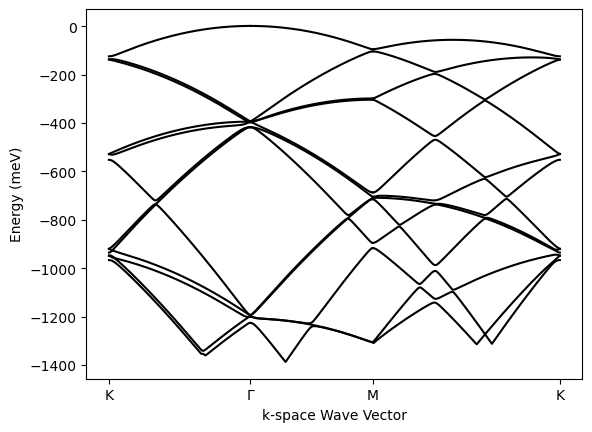

In [3]:
path_points = 1000
num_bands = 12
is_closed_path = False

start_time_1 = time.time()
obj.plot_BZ(path_points, num_bands, is_closed_path)
print("total time", time.time() - start_time_1)

0.2731349468231201


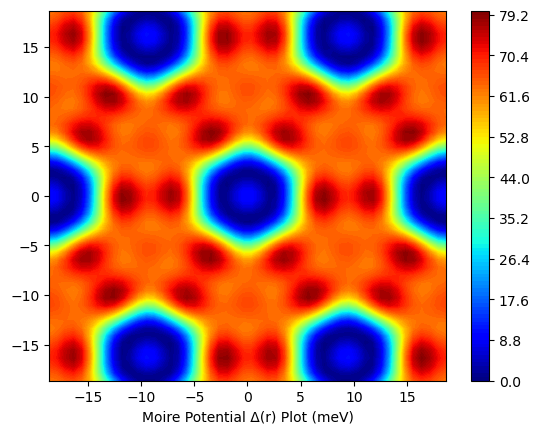

In [4]:
units = 1

start_time_2 = time.time()
obj.plot_moire_potential(units)
print(time.time() - start_time_2)

10.269543409347534


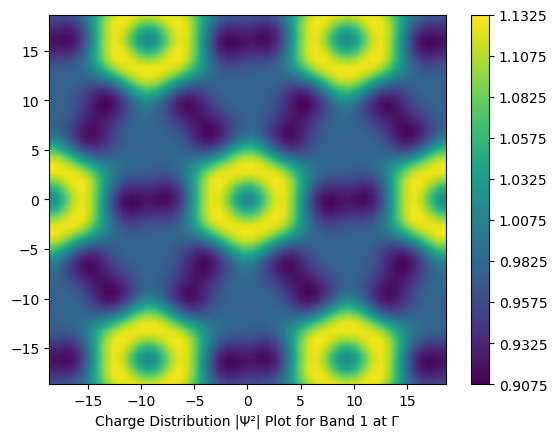

In [5]:
top_band_index = 60
units = 1
point = obj.Gamma

start_time_3 = time.time()
obj.plot_charge_dist(point, top_band_index, units)
print(time.time() - start_time_3)

In [6]:
# from mpcontribs.client import Client
# client = Client()
# dir(client) # show available resources

In [7]:
# !pip install mpcontribs-client